In [30]:
# --- Import de packages ---

import pandas as pd
import taceconomics
from datetime import datetime
import numpy as np

from gdeltdoc import GdeltDoc, Filters
from datetime import datetime, timedelta
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.metrics import (
    roc_auc_score, roc_curve, confusion_matrix, 
    precision_score, recall_score, f1_score, accuracy_score
)
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [50]:
# --- API Key et dates ---

taceconomics.api_key = "sk_o24BhJRqVpIvxVSXX3yiKRGgpDEejmyJ8pfLFX2q22s"  
start_date = '2023-01-01'
end_date = datetime.today().strftime("%Y-%m-%d")

In [51]:
# --- Importation des données ---

# Taux de change EUR/USD
usd_eur = taceconomics.getdata(f"EXR/EUR/WLD?start_date={start_date}")
usd_eur.columns = ["usd_eur"]
usd_eur = usd_eur.dropna()
eur_usd = 1 / usd_eur  # Inversion pour avoir EUR/USD
eur_usd.columns = ["close"]
eur_usd.index = pd.to_datetime(eur_usd.index)

print(eur_usd.head(10))
print(eur_usd.shape)
print(eur_usd.columns)

               close
timestamp           
2023-01-01  1.070452
2023-01-02  1.067737
2023-01-03  1.054652
2023-01-04  1.060839
2023-01-05  1.052192
2023-01-06  1.066382
2023-01-07  1.066382
2023-01-08  1.065598
2023-01-09  1.073445
2023-01-10  1.073860
(994, 1)
Index(['close'], dtype='object')


In [52]:
# --- Indicateurs de base ---

# Rendement logarithmique quotidien
eur_usd["rendement_log"] = np.log(eur_usd["close"] / eur_usd["close"].shift(1))

# Volatilité glissante (30 jours) basée sur les rendements log
eur_usd["vol_30j"] = eur_usd["rendement_log"].rolling(window=30).std()

# Rendement logarithmique cumulé à 10 jours (passé)
eur_usd["rendement_log_10j"] = np.log(eur_usd["close"] / eur_usd["close"].shift(10))

# print(eur_usd.head(60))
print(eur_usd.shape)
print(eur_usd.columns)

(994, 4)
Index(['close', 'rendement_log', 'vol_30j', 'rendement_log_10j'], dtype='object')


In [53]:
# --- Cible --- 

# Rendement logarithmique FUTUR à 10 jours (cohérent avec les autres features)
eur_usd["rendement_futur_10j"] = np.log(eur_usd["close"].shift(-10) / eur_usd["close"])

# Seuils de choc dynamiques (±1 × volatilité sur 10 jours)
# La vol sur 10j est approximativement vol_quotidienne × sqrt(10)
seuil_choc = eur_usd["vol_30j"] * np.sqrt(10) # 1*vol car 2*vol est trop rare (4-5% des cas)

# Target : 1 si choc de volatilité (hausse OU baisse), 0 sinon
eur_usd["target"] = (
    (eur_usd["rendement_futur_10j"].abs() >= seuil_choc)
).astype(int)

print(eur_usd.shape)
print(eur_usd.columns)

# Distribution
print(f"\nDistribution de la target:")
print(eur_usd['target'].value_counts())
print(f"Taux de chocs: {eur_usd['target'].mean():.2%}")

(994, 6)
Index(['close', 'rendement_log', 'vol_30j', 'rendement_log_10j',
       'rendement_futur_10j', 'target'],
      dtype='object')

Distribution de la target:
target
0    748
1    246
Name: count, dtype: int64
Taux de chocs: 24.75%


In [54]:
# --- Indicateurs techniques ---

# Moyennes mobiles
eur_usd["mm7"] = eur_usd["close"].rolling(window=7).mean()
eur_usd["mm21"] = eur_usd["close"].rolling(window=21).mean()

# Bandes de Bollinger (20 jours)
rolling_mean_20 = eur_usd["close"].rolling(window=20).mean()
rolling_std_20 = eur_usd["close"].rolling(window=20).std()
eur_usd["boll_haut"] = rolling_mean_20 + 2 * rolling_std_20
eur_usd["boll_bas"] = rolling_mean_20 - 2 * rolling_std_20

# RSI
def calculer_rsi(series, window=14):
    delta = series.diff()
    gain = np.where(delta > 0, delta, 0)
    perte = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain, index=series.index).rolling(window=window).mean()
    avg_perte = pd.Series(perte, index=series.index).rolling(window=window).mean()
    rs = avg_gain / avg_perte
    rsi = 100 - (100 / (1 + rs))
    return rsi

eur_usd["rsi_14j"] = calculer_rsi(eur_usd["close"])

# --- Nettoyage final ---

eur_usd = eur_usd.drop(columns=["rendement_futur_10j"])
eur_usd = eur_usd.dropna().copy()

# print(eur_usd.head(60))
print(eur_usd.shape)
print(eur_usd.columns)
print(eur_usd.iloc[0])

(964, 10)
Index(['close', 'rendement_log', 'vol_30j', 'rendement_log_10j', 'target',
       'mm7', 'mm21', 'boll_haut', 'boll_bas', 'rsi_14j'],
      dtype='object')
close                 1.101249
rendement_log         0.013846
vol_30j               0.005340
rendement_log_10j     0.013520
target                1.000000
mm7                   1.089052
mm21                  1.086332
boll_haut             1.095692
boll_bas              1.077963
rsi_14j              78.506598
Name: 2023-02-01 00:00:00, dtype: float64


In [63]:
eur_usd.to_excel("data/test_eur_usd_data.xlsx")

In [55]:
# --- Indicateurs de sentiment ---

# Télécharger VADER (une seule fois)
nltk.download('vader_lexicon')

# Initialiser VADER globalement
sid = SentimentIntensityAnalyzer()

def recuperer_sentiment_gdelt(start_date, end_date, keyword="EUR/USD", language='eng', chunk_days=30, num_records=250):
    """
    Récupère les articles GDELT pour un mot-clé donné entre deux dates,
    calcule le score de sentiment pour chaque article, et agrège par jour.
    """
    # Convertir les dates
    start = datetime.strptime(start_date, "%Y-%m-%d")
    end = datetime.strptime(end_date, "%Y-%m-%d")

    gd = GdeltDoc()
    all_articles = []

    current_start = start
    while current_start <= end:
        current_end = min(current_start + timedelta(days=chunk_days), end)

        # print(f"Récupération articles: {current_start.date()} -> {current_end.date()}")

        # Créer filtre
        f = Filters(
            start_date=current_start.strftime("%Y-%m-%d"),
            end_date=current_end.strftime("%Y-%m-%d"),
            num_records=num_records,
            keyword=keyword,
            language=language
        )

        # Récupérer articles
        try:
            articles_df = gd.article_search(f)
            if not articles_df.empty:
                all_articles.append(articles_df)
        except Exception as e:
            print(f"Erreur récupération: {e}")

        current_start = current_end + timedelta(days=1)

    # Vérifier si on a récupéré des articles
    if not all_articles:
        print("Aucun article trouvé pour la période.")
        return pd.DataFrame(columns=['date', 'sentiment'])

    df = pd.concat(all_articles, ignore_index=True)

    # Parsing date GDELT
    def convertir_date_gdelt(date_str):
        try:
            # Format AAAAMMJJTHHMMSSZ ou AAAAMMJJ
            date_part = date_str.split('T')[0]
            return datetime.strptime(date_part, "%Y%m%d").date()
        except:
            return pd.NaT

    df['date'] = df['seendate'].apply(convertir_date_gdelt)
    df = df.dropna(subset=['date'])
    df['date'] = pd.to_datetime(df['date'])

    # Calculer sentiment pour chaque article
    def calculer_sentiment(texte):
        if isinstance(texte, str) and texte.strip():
            return sid.polarity_scores(texte)['compound']
        return 0

    df['sentiment'] = df['title'].apply(calculer_sentiment)

    # Agréger par jour : score moyen par jour
    df_daily = df.groupby('date')['sentiment'].mean().reset_index()

    return df_daily

start_date = eur_usd.iloc[0].name.strftime("%Y-%m-%d")
end_date = eur_usd.iloc[-1].name.strftime("%Y-%m-%d")

print(f"Récupération sentiment GDELT de {start_date} à {end_date}")

df_sentiment = recuperer_sentiment_gdelt(
    start_date=start_date,
    end_date=end_date,
    keyword="EUR/USD",
    language='eng',
    chunk_days=30,
    num_records=250
)

df_sentiment = df_sentiment.groupby('date')['sentiment'].mean()
df_sentiment.index = pd.to_datetime(df_sentiment.index)

print(df_sentiment.head(10))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/noe/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Récupération sentiment GDELT de 2023-02-01 à 2025-10-05
date
2023-02-01   -0.061029
2023-02-02   -0.012873
2023-02-03   -0.055400
2023-02-04   -0.140500
2023-02-05    0.680800
2023-02-06   -0.028900
2023-02-07   -0.111200
2023-02-08   -0.132730
2023-02-09   -0.083567
2023-02-10   -0.164633
Name: sentiment, dtype: float64


In [56]:
# --- Fusion des données de sentiment avec les données EUR/USD ---

eur_usd = eur_usd.merge(df_sentiment.rename("sentiment"), left_index=True, right_index=True, how='left')

# Remplir les NaN si aucun article
eur_usd['sentiment'] = eur_usd['sentiment'].fillna(0)

print(eur_usd.head(10))
print(eur_usd.isna().sum())

               close  rendement_log   vol_30j  rendement_log_10j  target  \
timestamp                                                                  
2023-02-01  1.101249       0.013846  0.005340           0.013520       1   
2023-02-02  1.090477      -0.009830  0.005661           0.002994       0   
2023-02-03  1.082778      -0.007085  0.005315          -0.005527       0   
2023-02-04  1.082778       0.000000  0.005233          -0.008634       0   
2023-02-05  1.079051      -0.003448  0.005023          -0.009589       0   
2023-02-07  1.072938      -0.005681  0.004566          -0.013252       0   
2023-02-08  1.071639      -0.001212  0.004573          -0.014464       0   
2023-02-09  1.074056       0.002253  0.004585          -0.012081       0   
2023-02-10  1.069919      -0.003859  0.004443          -0.013947       0   
2023-02-11  1.070148       0.000214  0.004442          -0.014802       0   

                 mm7      mm21  boll_haut  boll_bas    rsi_14j  sentiment  
timestamp  

In [57]:
# --- Variables PCA & Clustering ---

# Copie sécurisée
df = eur_usd.copy()

# Sélection des features quantitatives 
# On exclut les colonnes non numériques ou non pertinentes
features = df.drop(columns=['target'], errors='ignore').select_dtypes(include=[np.number])

# Standardisation 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# PCA (réduction de dimension) 
# Garde assez de composantes pour expliquer 90 % de la variance
pca = PCA(n_components=0.9, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Créer un DataFrame avec les composantes principales
df_pca = pd.DataFrame(
    X_pca,
    columns=[f'PC{i+1}' for i in range(X_pca.shape[1])],
    index=df.index
)

# KMeans (clustering sur l’espace PCA) 
# Trouve des structures cachées dans les données
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['cluster_kmeans'] = kmeans.fit_predict(X_pca)

# Fusion finale 
df_extended = pd.concat([df, df_pca], axis=1)

# Résumé 
print(f"Variance expliquée par PCA : {pca.explained_variance_ratio_.sum():.2%}")
print(f"Nombre de composantes PCA retenues : {pca.n_components_}")
print(f"Forme finale du DataFrame : {df_extended.shape}")
print(df_extended.iloc[0])
print(df_extended.iloc[-1])
print(df_extended.columns)

Variance expliquée par PCA : 97.26%
Nombre de composantes PCA retenues : 5
Forme finale du DataFrame : (964, 17)
close                 1.101249
rendement_log         0.013846
vol_30j               0.005340
rendement_log_10j     0.013520
target                1.000000
mm7                   1.089052
mm21                  1.086332
boll_haut             1.095692
boll_bas              1.077963
rsi_14j              78.506598
sentiment            -0.061029
cluster_kmeans        2.000000
PC1                   0.174349
PC2                   3.155502
PC3                  -0.145757
PC4                   0.667207
PC5                   2.338900
Name: 2023-02-01 00:00:00, dtype: float64
close                 1.171173
rendement_log        -0.002511
vol_30j               0.003541
rendement_log_10j    -0.002762
target                0.000000
mm7                   1.172869
mm21                  1.174905
boll_haut             1.184814
boll_bas              1.165228
rsi_14j              45.166598
sentimen

In [25]:
#----Variables macro----

start_date = df_extended.iloc[0].name.strftime("%Y-%m-%d")
print(start_date)
end_date = df_extended.iloc[-1].name.strftime("%Y-%m-%d")
print(end_date)

print(f"Récupération variables macro de {start_date} à {end_date}")

# Inflation
infl_eur = taceconomics.getdata(f"EUROSTAT/EI_CPHI_M_CP-HI00_NSA_HICP2015/EUZ?collapse=D&transform=growth_yoy&start_date={start_date}")
infl_us = taceconomics.getdata(f"FRED/CPIAUCSL/USA?collapse=D&transform=growth_yoy&start_date={start_date}")

 # Taux interets
ti_eur = taceconomics.getdata(f"ECB/FM_D_EUR_4F_KR_DFR_LEV/EUZ?collapse=D&collapse_mode=end_of_period&start_date={start_date}")
ti_us = taceconomics.getdata(f"DS/USPRATE./WLD?collapse=D&start_date={start_date}")

# Dataframe macro
df_macro = pd.DataFrame()
df_macro["inflation_eur"] = infl_eur
df_macro["inflation_us"] = infl_us
df_macro["interest_rate_eur"] = ti_eur
df_macro["interest_rate_us"] = ti_us

df_macro = df_macro.ffill()

print(df_macro.iloc[0])
print(df_macro.iloc[-1])
print(df_macro.shape)

2023-03-05
2025-10-05
Récupération variables macro de 2023-03-05 à 2025-10-05
inflation_eur        6.884501
inflation_us         4.931349
interest_rate_eur    2.500000
interest_rate_us     5.000000
Name: 2023-03-05, dtype: float64
inflation_eur        2.227488
inflation_us         2.939220
interest_rate_eur    2.000000
interest_rate_us     4.250000
Name: 2025-09-30, dtype: float64
(941, 4)


In [61]:
df_final = pd.concat([df_extended, df_macro], axis=1)
print(df_final.tail(10))
print(df_final.columns)

           timestamp  eur_usd  taux_croissance  vol  rendement_10j  \
2025-09-21       NaT      NaN              NaN  NaN            NaN   
2025-09-22       NaT      NaN              NaN  NaN            NaN   
2025-09-23       NaT      NaN              NaN  NaN            NaN   
2025-09-24       NaT      NaN              NaN  NaN            NaN   
2025-09-25       NaT      NaN              NaN  NaN            NaN   
2025-09-26       NaT      NaN              NaN  NaN            NaN   
2025-09-27       NaT      NaN              NaN  NaN            NaN   
2025-09-28       NaT      NaN              NaN  NaN            NaN   
2025-09-29       NaT      NaN              NaN  NaN            NaN   
2025-09-30       NaT      NaN              NaN  NaN            NaN   

            seuil_haut  seuil_bas  target  moyenne_mobile_7j  \
2025-09-21         NaN        NaN     NaN                NaN   
2025-09-22         NaN        NaN     NaN                NaN   
2025-09-23         NaN        NaN    

Préparation des données...
Shape: (964, 17)
Target rate: 0.255
Features: (964, 16)

Train: (771, 16) | Test: (193, 16)
Target train: 0.268 | test: 0.202

Entraînement XGBoost...

Évaluation sur test...

AUC:        0.4795
Gini:       -0.0410
Seuil:      0.8076

Confusion Matrix:
  TN= 123  FP=  31
  FN=  25  TP=  14

Precision:  0.3111
Recall:     0.3590
F1-Score:   0.3333
Accuracy:   0.7098


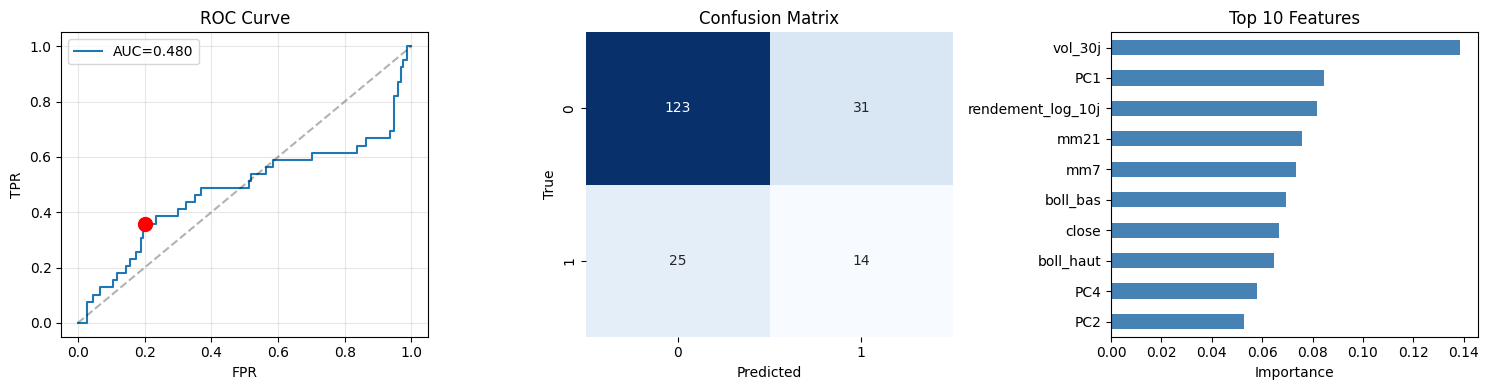


Top 5 features:
vol_30j              0.138696
PC1                  0.084664
rendement_log_10j    0.081622
mm21                 0.075987
mm7                  0.073327
dtype: float32


In [58]:
"""
XGBoost pour prédiction d'un choc à 2 semaines sur EUR/USD.
"""

import warnings
warnings.filterwarnings("ignore")

# --- config ---

TRAIN_SIZE = 0.80  # 80% train, 20% test

# --- préparation des données ---

print("Préparation des données...")

# Tri par date
df = df_extended.sort_values("timestamp").reset_index(drop=True)

# La target contient déjà le shift(-10), pas besoin de le refaire

df = df.dropna(subset=["target"])

print(f"Shape: {df.shape}")
print(f"Target rate: {df['target'].mean():.3f}")


# --- features et target ---

# Features
feature_cols = [
    'close', 'rendement_log', 'vol_30j', 'rendement_log_10j',
    'mm7', 'mm21', 'boll_haut', 'boll_bas', 'rsi_14j', 
    'sentiment', 'cluster_kmeans', 
    'PC1', 'PC2', 'PC3', 'PC4', 'PC5'
]

X = df[feature_cols].fillna(df[feature_cols].median())
y = df["target"].astype(int)

print(f"Features: {X.shape}")

# --- split train/test temporel ---

split_idx = int(len(df) * TRAIN_SIZE)

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"\nTrain: {X_train.shape} | Test: {X_test.shape}")
print(f"Target train: {y_train.mean():.3f} | test: {y_test.mean():.3f}")

# --- entraînement XGBoost ---

print("\nEntraînement XGBoost...")

model = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.05,
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)

model.fit(X_train, y_train)

# --- prédictions et évaluation ---

print("\nÉvaluation sur test...")

# Probabilités
probs_test = model.predict_proba(X_test)[:, 1]

# Métriques ROC
auc = roc_auc_score(y_test, probs_test)
gini = 2 * auc - 1
fpr, tpr, thresholds = roc_curve(y_test, probs_test)

# Seuil optimal (Youden)
youden_idx = np.argmax(tpr - fpr)
threshold = thresholds[youden_idx]

# Prédictions binaires
preds = (probs_test >= threshold).astype(int)

# Métriques
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
precision = precision_score(y_test, preds, zero_division=0)
recall = recall_score(y_test, preds, zero_division=0)
f1 = f1_score(y_test, preds, zero_division=0)
accuracy = accuracy_score(y_test, preds)

print(f"\n{'='*50}")
print(f"AUC:        {auc:.4f}")
print(f"Gini:       {gini:.4f}")
print(f"Seuil:      {threshold:.4f}")
print(f"\nConfusion Matrix:")
print(f"  TN={tn:4d}  FP={fp:4d}")
print(f"  FN={fn:4d}  TP={tp:4d}")
print(f"\nPrecision:  {precision:.4f}")
print(f"Recall:     {recall:.4f}")
print(f"F1-Score:   {f1:.4f}")
print(f"Accuracy:   {accuracy:.4f}")
print(f"{'='*50}")

# --- Visualisations ---

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# ROC Curve
axes[0].plot(fpr, tpr, label=f"AUC={auc:.3f}")
axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.3)
axes[0].scatter(fpr[youden_idx], tpr[youden_idx], c='red', s=100, zorder=5)
axes[0].set_xlabel("FPR")
axes[0].set_ylabel("TPR")
axes[0].set_title("ROC Curve")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Matrice de confusion
cm = np.array([[tn, fp], [fn, tp]])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[1])
axes[1].set_title("Confusion Matrix")
axes[1].set_ylabel("True")
axes[1].set_xlabel("Predicted")

# Feature Importance
importance = pd.Series(model.feature_importances_, index=feature_cols).sort_values(ascending=True)
importance.tail(10).plot(kind='barh', ax=axes[2], color='steelblue')
axes[2].set_xlabel("Importance")
axes[2].set_title("Top 10 Features")

plt.tight_layout()
plt.show()

print("\nTop 5 features:")
print(importance.sort_values(ascending=False).head(5))